#Testando os Modelos de Regressão com R²

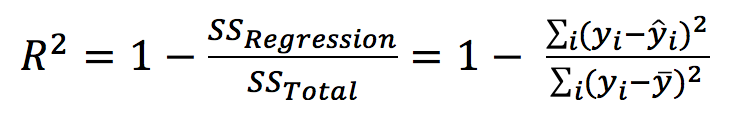

## imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
    
from functools import wraps

## Carregando Base de Dados

In [2]:
!rm -r MLUD
!git clone https://github.com/Crissky/MLUD.git

Cloning into 'MLUD'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (195/195), done.
remote: Compressing objects: 100% (185/185), done.
remote: Total 195 (delta 79), reused 44 (delta 4), pack-reused 0
Receiving objects: 100% (195/195), 1.35 MiB | 1.52 MiB/s, done.
Resolving deltas: 100% (79/79), done.


## Funções de Pré-Processamento

In [3]:
def loadDataset(filename):
    baseDeDados = pd.read_csv(filename, delimiter=';')
    X = baseDeDados.iloc[:,:-1].values
    y = baseDeDados.iloc[:,-1].values

    return X, y, baseDeDados

def fillMissingData(X, inicioColuna, fimColuna):
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    X[:,inicioColuna:fimColuna + 1] = imputer.fit_transform(X[:,inicioColuna:fimColuna + 1])

    return X

#só funciona se i = 0 ou i = ultima coluna
def computeCategorization(X, i):
    labelencoder_X = LabelEncoder()
    X[:, i] = labelencoder_X.fit_transform(X[:, i])

    #one hot encoding
    D = pd.get_dummies(X[:,i]).values
    if(i == 0):
        X = X[:,1:]
        X = np.insert(X, 0, D, axis=1)

        #removendo dummy variable trap
        X = X[:,1:]
    else:
        X = X[:,:i]
        for j in range(0, D.shape[1]):
            X = np.insert(X, i, D[:,j], axis=1)

        #removendo dummy variable trap
        X = X[:,:-1]

    return X

def splitTrainTestSets(X, y, testSize):
    XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = testSize)

    return XTrain, XTest, yTrain, yTest

def computeScaling(X):
    scale = StandardScaler()
    X = scale.fit_transform(X)

    return X, scale

## Regressão Linear

In [4]:
def computeLinearRegressionModel(X, y):
    regressor = LinearRegression()
    regressor.fit(X, y)

    return regressor

def runLinearRegressionExample(filename):
    X, y, csv = loadDataset(filename)

    start_time = time.time()
    regressor = computeLinearRegressionModel(X, y)
    elapsed_time = time.time() - start_time
    print("Compute Linear Regression: %.2f" % elapsed_time, "segundos.")

    return r2_score(y, regressor.predict(X))

## Regressão Polinomial

In [5]:
def computePolynomialLinearRegressionModel(X, y, d):
    polynomialFeatures = PolynomialFeatures(degree = d)
    XPoly = polynomialFeatures.fit_transform(X)

    polyLinearRegression = LinearRegression()
    polyLinearRegression.fit(XPoly, y)

    return XPoly, polyLinearRegression

def runPolynomialLinearRegressionExample(filename, degree):
    X, y, csv = loadDataset(filename)

    start_time = time.time()
    XPoly, regressor = computePolynomialLinearRegressionModel(X, y, degree)
    elapsed_time = time.time() - start_time
    print("Compute Polynomial Linear Regression: %.2f" % elapsed_time, "segundos.")

    return r2_score(y, regressor.predict(XPoly))

## Regressão de Vetor Suporte

In [6]:
def computeSupportVectorRegressionModel(X, y, k, d=2):
    if (k == 'poly'):
        regressor = SVR(kernel=k, degree=d)
    else:
        regressor = SVR(kernel=k)
    regressor.fit(X, np.ravel(y))           # Como o y foi previamente transformado em matriz, o np.ravel o converte novamente para um vetor

    return regressor

def runSupportVectorRegressionExample(filename, kernel='linear', degree=2, printY=False):
    X, y, csv = loadDataset(filename)
    
    X, scaleX = computeScaling(X)
    y, scaleY = computeScaling(np.reshape(y, (-1, 1)))          #np.reshape(y, (-1, 1)) transforma y em uma matriz

    start_time = time.time()
    regressor = computeSupportVectorRegressionModel(X, y, kernel, degree)
    elapsed_time = time.time() - start_time
    print('Compute Support Vector Regression with kernel "%s": %.2f' % (kernel.upper(), elapsed_time), 'segundos.')
    
    return r2_score(y, regressor.predict(X))

## Regressão com Árvore de Decisão

In [7]:
def computeDecisionTreeRegressionModel(X, y):
    regressor = DecisionTreeRegressor()
    regressor.fit(X, y)

    return regressor

def runDecisionTreeRegressionExample(filename):
    X, y, csv = loadDataset(filename)

    start_time = time.time()
    regressor = computeDecisionTreeRegressionModel(X, y)
    elapsed_time = time.time() - start_time
    print("Compute Decision Tree Regression: %.2f" % elapsed_time, "segundos.")

    return r2_score(y, regressor.predict(X))

## Regressão de Floresta Aleatória

In [8]:
def computeRandomForestRegressionModel(X, y, numberOfTrees):
    regressor = RandomForestRegressor(n_estimators = numberOfTrees)
    regressor.fit(X, y)

    return regressor

def runRandomForestRegressionExample(filename, numberOfTrees):
    X, y, csv = loadDataset(filename)

    start_time = time.time()
    regressor = computeRandomForestRegressionModel(X, y, numberOfTrees)
    elapsed_time = time.time() - start_time
    print("Compute Random Forest Regression: %.2f" % elapsed_time, "segundos.")

    return r2_score(y, regressor.predict(X))

## Testando os Modelos de Regressão

In [9]:
def evaluateAllRegressionModels(filename):
    regressors_score = dict()
    regressors_score['LinearRegression'] = runLinearRegressionExample(filename)
    regressors_score['PolynomialLinearRegression-degree2'] = runPolynomialLinearRegressionExample(filename, 2)
    regressors_score['PolynomialLinearRegression-degree3'] = runPolynomialLinearRegressionExample(filename, 3)
    regressors_score['PolynomialLinearRegression-degree4'] = runPolynomialLinearRegressionExample(filename, 4)
    regressors_score['PolynomialLinearRegression-degree5'] = runPolynomialLinearRegressionExample(filename, 5)
    regressors_score['SupportVectorRegression-linear'] = runSupportVectorRegressionExample(filename, kernel='linear')
    regressors_score['SupportVectorRegression-poly-degree2'] = runSupportVectorRegressionExample(filename, kernel='poly', degree=2)
    regressors_score['SupportVectorRegression-poly-degree3'] = runSupportVectorRegressionExample(filename, kernel='poly', degree=3)
    regressors_score['SupportVectorRegression-poly-degree4'] = runSupportVectorRegressionExample(filename, kernel='poly', degree=4)
    regressors_score['SupportVectorRegression-poly-degree5'] = runSupportVectorRegressionExample(filename, kernel='poly', degree=5)
    regressors_score['SupportVectorRegression-rbf'] = runSupportVectorRegressionExample(filename, kernel='rbf')
    regressors_score['DecisionTreeRegression'] = runDecisionTreeRegressionExample(filename)
    regressors_score['RandomForestRegression-numberOfTrees10'] = runRandomForestRegressionExample(filename, numberOfTrees=10)
    regressors_score['RandomForestRegression-numberOfTrees50'] = runRandomForestRegressionExample(filename, numberOfTrees=50)
    regressors_score['RandomForestRegression-numberOfTrees100'] = runRandomForestRegressionExample(filename, numberOfTrees=100)
    regressors_score['RandomForestRegression-numberOfTrees200'] = runRandomForestRegressionExample(filename, numberOfTrees=200)
    regressors_score['RandomForestRegression-numberOfTrees500'] = runRandomForestRegressionExample(filename, numberOfTrees=500)
    
    regressors_score = dict(sorted(regressors_score.items(), key=lambda item: -item[1]))

    print('\nImprimindo as Pontuações:\n'.upper())
    for key, value in regressors_score.items():
        print(key, ' '*(39 - len(key)), "Score:", value)
        print()
    

In [10]:
evaluateAllRegressionModels('MLUD/Aula11/salary.csv')

Compute Linear Regression: 0.00 segundos.
Compute Polynomial Linear Regression: 0.00 segundos.
Compute Polynomial Linear Regression: 0.00 segundos.
Compute Polynomial Linear Regression: 0.00 segundos.
Compute Polynomial Linear Regression: 0.00 segundos.
Compute Support Vector Regression with kernel "LINEAR": 0.00 segundos.
Compute Support Vector Regression with kernel "POLY": 0.00 segundos.
Compute Support Vector Regression with kernel "POLY": 0.00 segundos.
Compute Support Vector Regression with kernel "POLY": 0.00 segundos.
Compute Support Vector Regression with kernel "POLY": 0.00 segundos.
Compute Support Vector Regression with kernel "RBF": 0.00 segundos.
Compute Decision Tree Regression: 0.00 segundos.
Compute Random Forest Regression: 0.02 segundos.
Compute Random Forest Regression: 0.07 segundos.
Compute Random Forest Regression: 0.13 segundos.
Compute Random Forest Regression: 0.22 segundos.
Compute Random Forest Regression: 0.55 segundos.

IMPRIMINDO AS PONTUAÇÕES:

DecisionT